# Evaluation of Learned Decoder
The purpose of this notebook is to evaluate the effectiveness of the learned decoders from CNN and GAN

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

import wandb
import datetime
desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA, FashionMURA
from utils.data import load_data
from utils.transforms import Noise_dB, Normalize_01
from reconstruct import RECON_CNN
from MURA import FFT_convolve
# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
# Log into WandB for logging project training runs
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

In [4]:
# Create params dict
date = '2024-01-11'#str(datetime.datetime.now().date())
params = {
    "image_size": 23,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 5,
    "model": f"decoder_cnn_{date}",
    "dataset": "MNIST_mura_noiseless",
    "scheduler_patience": 1,
    "snr": None, 
}

if params['image_size'] != 23:
    params['model'] = f"decoder_cnn_{date}_{params['image_size']}x{params['image_size']}_{params['dataset']}"
wandb.config = params

# Load data
train_data, test_data, loaders = load_data(params)

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 5
model: decoder_cnn_2024-01-11
dataset: MNIST_mura_noiseless
scheduler_patience: 1
snr: None


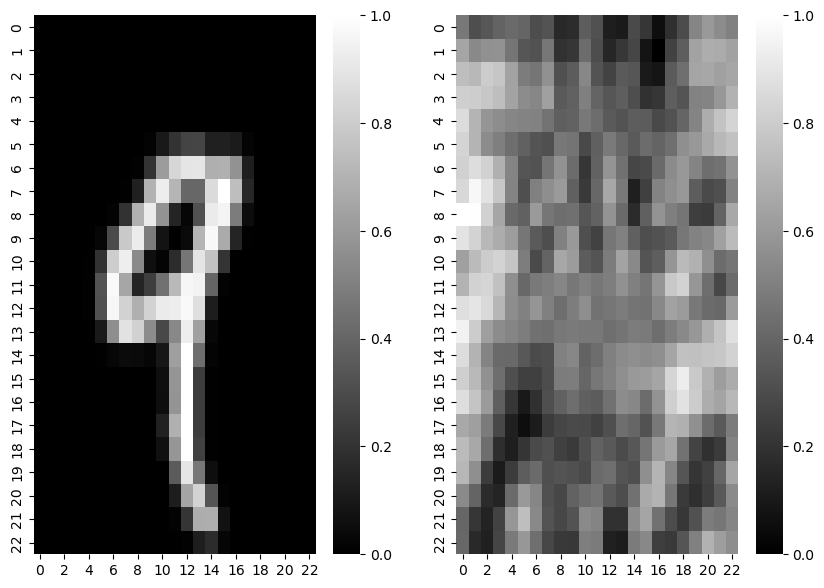

In [5]:
# Visualize data
fig, axs = plt.subplots(1,2, figsize=(10,7))
idx=4
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
# axs[0].axis('off')
# axs[1].axis('off')
plt.show()

# Define Model

In [6]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 5
model: decoder_cnn_2024-01-11
dataset: MNIST_mura_noiseless
scheduler_patience: 1
snr: None
kernel_size: 23
loss: MSELoss()
model_save_path: ../runs/decoder_cnn_2024-01-11/decoder_cnn_2024-01-11.pth
Weights loaded from ../runs/decoder_cnn_2024-01-11/decoder_cnn_2024-01-11.pth


In [7]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

../runs/decoder_cnn_2024-01-11/
Learned weights Shape: torch.Size([23, 23])


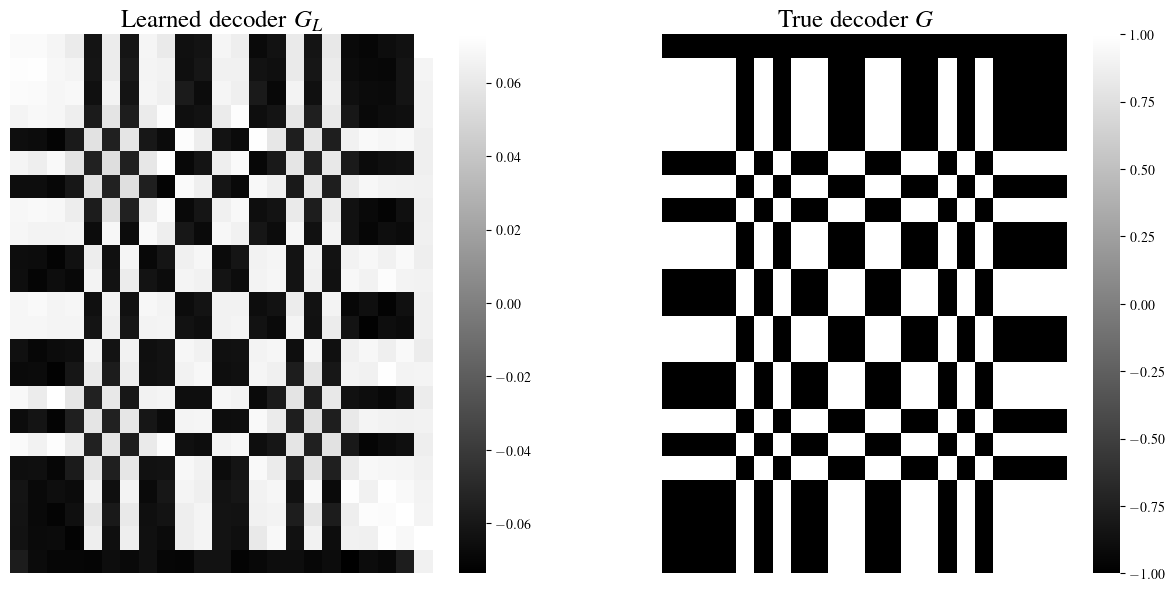

In [8]:
## Plot weights
print(model.RUN_DIR)
# ----------- Plot learned weights and target weights---- 
weight_map = list(model.parameters())[0].detach().squeeze(0).squeeze(0)
print('Learned weights Shape: {}'.format(weight_map.shape))

target_weights = train_data.G
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs = axs.ravel()
sns.heatmap(np.squeeze(weight_map.cpu().numpy()), cmap='gray', ax= axs[0])
sns.heatmap(target_weights, cmap='gray', ax= axs[1])
# axs[0].imshow(weight_map, cmap='gray')
# axs[1].imshow(target_weights, cmap='gray')
axs[0].set_title("Learned decoder $G_L$", fontsize=18)
axs[1].set_title("True decoder $G$", fontsize=18)
axs[0].axis('off')
axs[1].axis('off')
# axs[0].patch.set_edgecolor('black') 
# fig.savefig(model.RUN_DIR+'learned_vs_target_weights_v2.png',dpi=400)
plt.show()

../runs/decoder_cnn_2024-01-11/
Learned weights Shape: (23, 23)


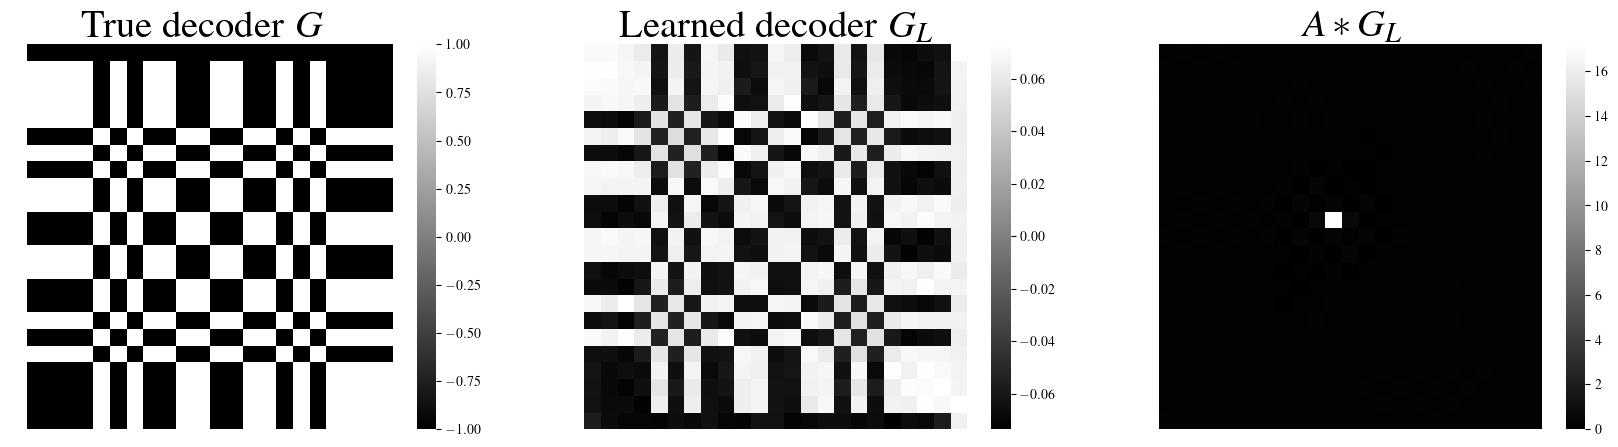

In [9]:
## Plot weights
print(model.RUN_DIR)
# ----------- Plot learned weights and target weights---- 
weight_map = list(model.parameters())[0].detach().squeeze(0).squeeze(0).numpy()
print('Learned weights Shape: {}'.format(weight_map.shape))

target_weights = train_data.G
aperture = train_data.A
FFT_A_G_L = FFT_convolve(aperture, weight_map)
fig, axs = plt.subplots(1,3, figsize=(21,5))
axs = axs.ravel()
sns.heatmap(target_weights, cmap='gray', ax= axs[0])
sns.heatmap(weight_map, cmap='gray', ax= axs[1])
sns.heatmap(FFT_A_G_L, cmap='gray', ax= axs[2])
# axs[0].imshow(weight_map, cmap='gray')
# axs[1].imshow(target_weights, cmap='gray')
axs[0].set_title("True decoder $G$", fontsize=28)
axs[1].set_title("Learned decoder $G_L$", fontsize=28)
axs[2].set_title("$A*G_L$", fontsize=28)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
# axs[0].patch.set_edgecolor('black') 
# fig.savefig(model.RUN_DIR+'learned_vs_target_weights_v2.png',dpi=400)
fig.savefig(model.RUN_DIR+'learned_vs_target_weights_delta.png',dpi=400)
plt.show()

# Test set evaluation

In [10]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [11]:
SSIM = StructuralSimilarityIndexMeasure()

In [12]:
result_dict = {}

In [27]:
# This is to load test sets with different levels of noise. Change level of noise
model.params['snr'] = None
model.params['dataset'] = 'MNIST'
# Load data
train_data, test_data, loaders = load_data(model.params)

if model.params.get('snr') is None:
    model.params['snr'] = 'noiseless'

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 5
model: decoder_cnn_2024-01-11
dataset: MNIST
scheduler_patience: 1
snr: None
kernel_size: 23
loss: MSELoss()
model_save_path: ../runs/decoder_cnn_2024-01-11/decoder_cnn_2024-01-11.pth


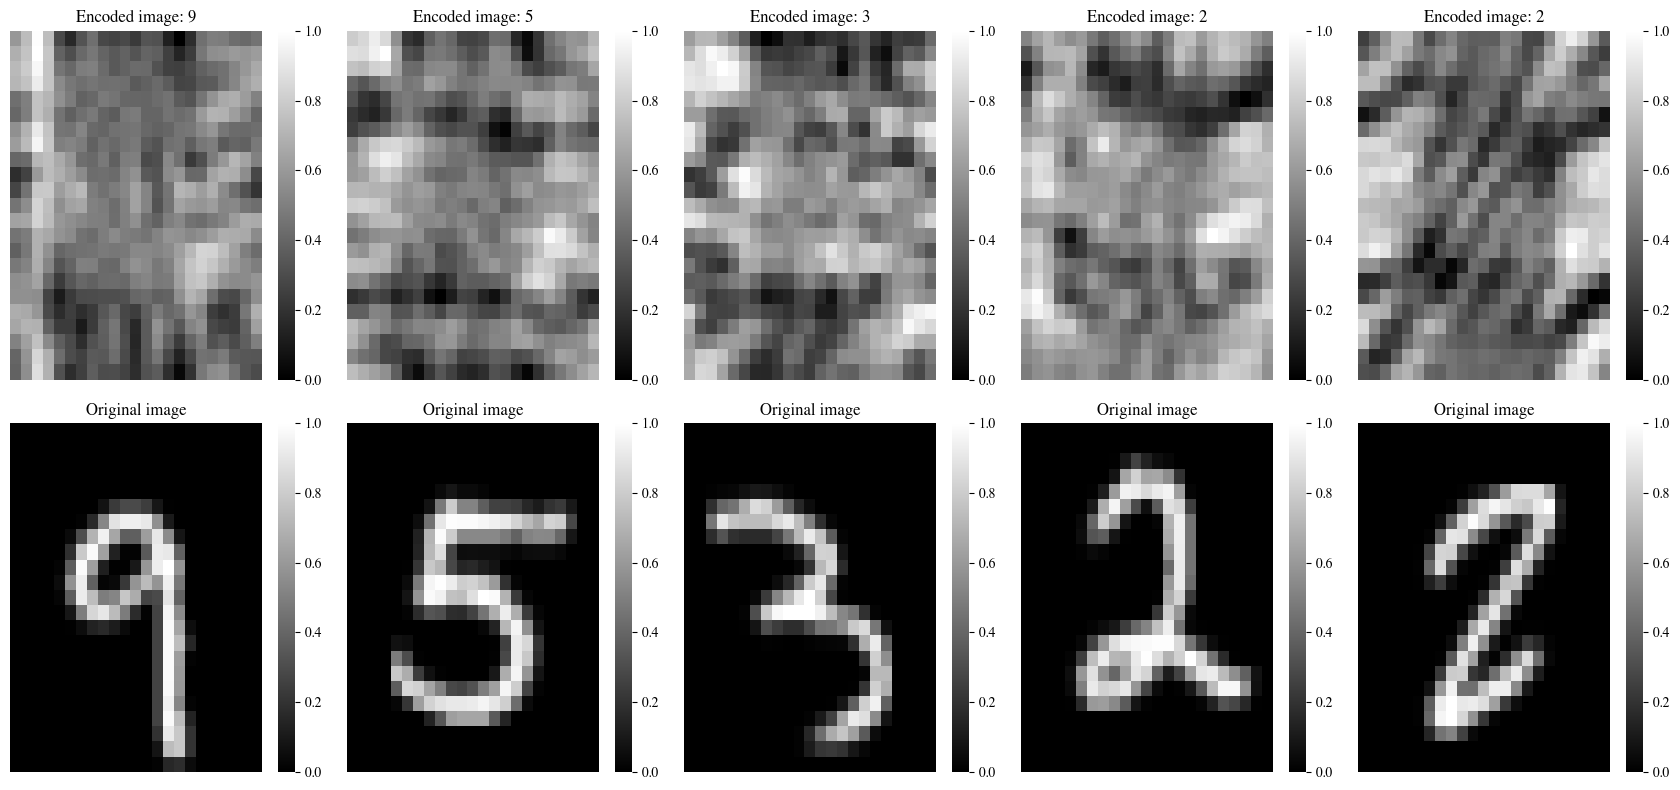

In [28]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [17,8],
})
# Printing 25 random images from the test dataset
random_samples = np.random.randint(1, len(test_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(loaders['test'].dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {loaders["test"].dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(loaders['test'].dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.savefig(model.RUN_DIR+ f"encoded_examples_snr_{model.params['snr']}.png")
plt.show()

# Calculate results with model

In [29]:
# Save MSE and SSIM evaluations in list
results = []
for i, data in enumerate(loaders['test']):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    # outputs = Normalize_01()(outputs)
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item(), model.params['snr']))
    # show_outputs(outputs, targets, inputs, iterator=i)

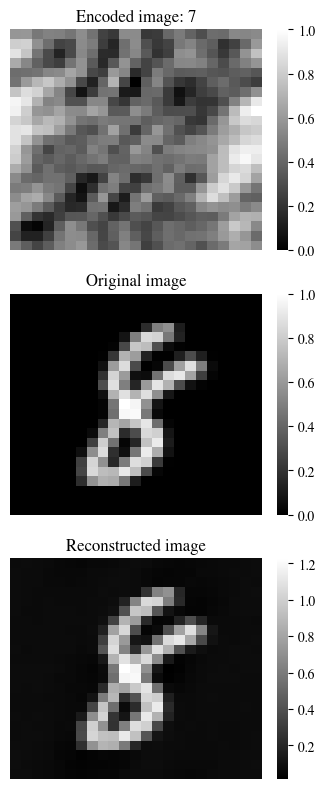

In [30]:
count = 0
for idx in range(outputs.shape[1]):
    plt.subplot(3, 5, count + 1)
    sns.heatmap(inputs[idx].squeeze(0).detach(), cmap='gray')
    plt.title(f'Encoded image: {loaders["test"].dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(3, 5, count + 6)
    sns.heatmap(targets[idx].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(3, 5, count + 11)
    sns.heatmap(outputs[idx].squeeze(0).detach(), cmap='gray')
    plt.title('Reconstructed image')
    plt.axis('off')
        
    count += 1
plt.tight_layout()

In [31]:
# Put results in dataframe
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', f'mse_{model.params["snr"]}', f'ssim_{model.params["snr"]}','snr'])
# df.to_csv(model.RUN_DIR + f'results_{model.params["dataset"]}_{model.params["snr"]}.csv')
df.head(5)

,inputs,outputs,targets,digits,mse_noiseless,ssim_noiseless,snr
0,"[[[tensor([0.4745, 0.3216, 0.2627, 0.3725, 0.5...","[[[tensor([0.1318, 0.1353, 0.1330, 0.1332, 0.1...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(7), tensor(2), tensor(1), tensor(0), t...",0.009112,0.838470,noiseless
1,"[[[tensor([0.2745, 0.4196, 0.3529, 0.5451, 0.5...","[[[tensor([0.0840, 0.0880, 0.0851, 0.0864, 0.0...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(6), tensor(0), tensor(5), tensor(4), t...",0.008393,0.844110,noiseless
2,"[[[tensor([0.6157, 0.7843, 0.8588, 0.8392, 0.5...","[[[tensor([-0.0084, -0.0088, -0.0107, -0.0148,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(3), tensor(6), tensor(1), tensor(1), t...",0.008746,0.834412,noiseless
3,"[[[tensor([0.6980, 0.6588, 0.5490, 0.4902, 0.3...","[[[tensor([0.1084, 0.1116, 0.1056, 0.1046, 0.0...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(4), tensor(7), tensor(1), tensor(2), t...",0.008503,0.829732,noiseless
4,"[[[tensor([0.5686, 0.4196, 0.3294, 0.4824, 0.6...","[[[tensor([0.1317, 0.1280, 0.1243, 0.1228, 0.1...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(2), tensor(8), tensor(3), tensor(8), t...",0.009196,0.846607,noiseless


In [25]:
result_dict[f'{model.params["snr"]}_results'] = df

In [32]:
df.describe()

,mse_noiseless,ssim_noiseless
count,100.000000,100.000000
mean,0.007819,0.861746
std,0.001325,0.026775
min,0.004757,0.795823
25%,0.007092,0.842716
50%,0.007958,0.859638
75%,0.008523,0.877976
max,0.012620,0.924843


# Plot examples from different quartiles

In [123]:
# Compute quartiles
q1 = df['ssim_noiseless'].quantile(0.25)
q2 = df['ssim_noiseless'].quantile(0.50)
q3 = df['ssim_noiseless'].quantile(0.75)

# # Select rows from each quartile
row_q1 = df[df['ssim_noiseless'] <= q1].sort_values(by='ssim_noiseless').iloc[0]
row_q2 = df[(df['ssim_noiseless'] > q1) & (df['ssim_noiseless'] <= q2)].sort_values(by='ssim_noiseless').iloc[-10]
row_q3 = df[(df['ssim_noiseless'] > q2) & (df['ssim_noiseless'] <= q3)].sort_values(by='ssim_noiseless').iloc[-10]
row_q4 = df[df['ssim_noiseless'] > q3].sort_values(by='ssim_noiseless').iloc[-1]

# # Display the selected rows
# print("Row from Quartile 1:")
# print(row_q1)
# print("\nRow from Quartile 2:")
# print(row_q2)
# print("\nRow from Quartile 3:")
# print(row_q3)
# print("\nRow from Quartile 4:")
# print(row_q4)

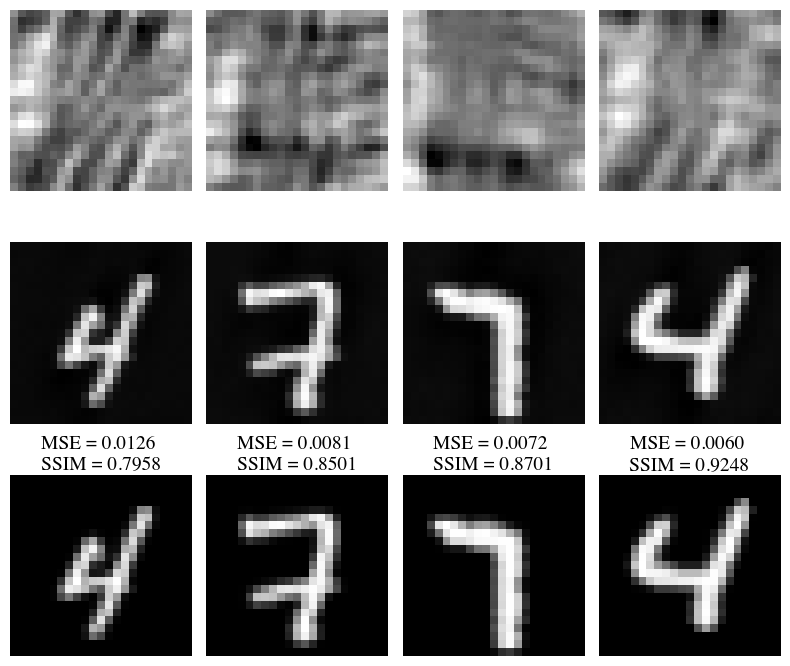

In [97]:
fig, axs = plt.subplots(3,4, figsize=(8,7))
axs = axs.ravel()
idx = np.random.randint(0,row_q1['inputs'].shape[0])
 
axs[0].imshow(row_q1['inputs'][idx].squeeze(0), cmap='gray')
axs[1].imshow(row_q2['inputs'][idx].squeeze(0), cmap='gray')
axs[2].imshow(row_q3['inputs'][idx].squeeze(0), cmap='gray')
axs[3].imshow(row_q4['inputs'][idx].squeeze(0), cmap='gray')

axs[4+0].imshow(row_q1['outputs'][idx].squeeze(0).detach(), cmap='gray')
axs[4+1].imshow(row_q2['outputs'][idx].squeeze(0).detach(), cmap='gray')
axs[4+2].imshow(row_q3['outputs'][idx].squeeze(0).detach(), cmap='gray')
axs[4+3].imshow(row_q4['outputs'][idx].squeeze(0).detach(), cmap='gray')

axs[8+0].imshow(row_q1['targets'][idx].squeeze(0), cmap='gray')
axs[8+1].imshow(row_q2['targets'][idx].squeeze(0), cmap='gray')
axs[8+2].imshow(row_q3['targets'][idx].squeeze(0), cmap='gray')
axs[8+3].imshow(row_q4['targets'][idx].squeeze(0), cmap='gray')

axs[4+0].set_title(f"MSE = {row_q1['mse_noiseless']:.4f} \nSSIM = {row_q1['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)
axs[4+1].set_title(f"MSE = {row_q2['mse_noiseless']:.4f} \nSSIM = {row_q2['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)
axs[4+2].set_title(f"MSE = {row_q3['mse_noiseless']:.4f} \nSSIM = {row_q3['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)
axs[4+3].set_title(f"MSE = {row_q4['mse_noiseless']:.4f} \nSSIM = {row_q4['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)

for i in range(3*4):
    axs[i].axis('off')
plt.tight_layout()
plt.show()

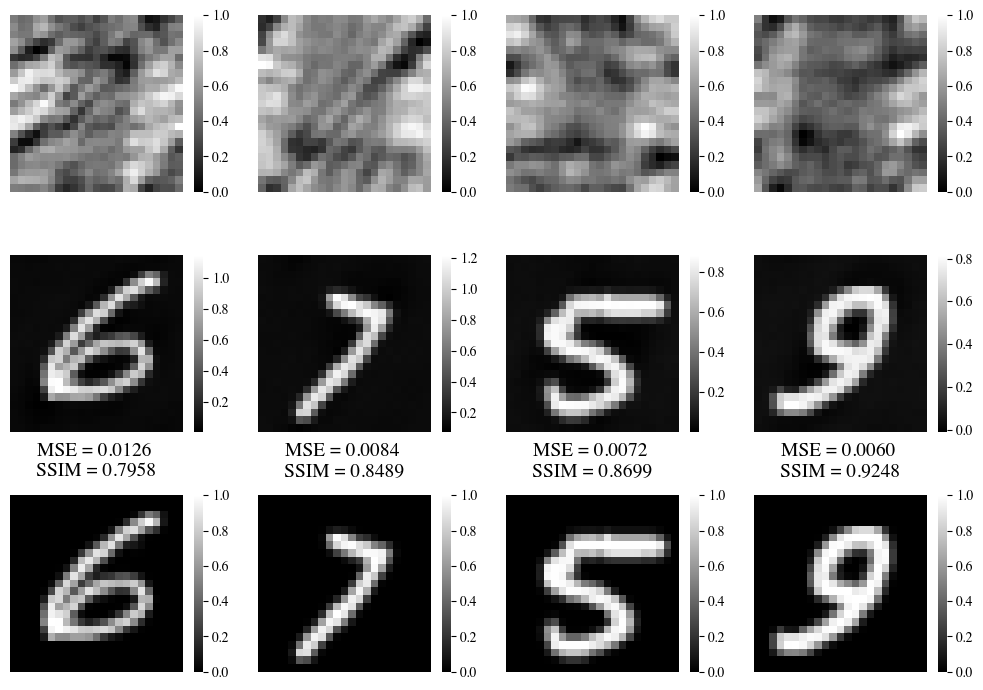

In [134]:
fig, axs = plt.subplots(3,4, figsize=(10,7))
axs = axs.ravel()
idx = np.random.randint(0,row_q1['inputs'].shape[0])

sns.heatmap(row_q1['inputs'][idx].squeeze(0), cmap='gray', ax =axs[0])
sns.heatmap(row_q2['inputs'][idx].squeeze(0), cmap='gray', ax =axs[1])
sns.heatmap(row_q3['inputs'][idx].squeeze(0), cmap='gray', ax =axs[2])
sns.heatmap(row_q4['inputs'][idx].squeeze(0), cmap='gray', ax =axs[3])

sns.heatmap(row_q1['outputs'][idx].squeeze(0).detach(), cmap='gray', ax =axs[4+0])
sns.heatmap(row_q2['outputs'][idx].squeeze(0).detach(), cmap='gray', ax =axs[4+1])
sns.heatmap(row_q3['outputs'][idx].squeeze(0).detach(), cmap='gray', ax =axs[4+2])
sns.heatmap(row_q4['outputs'][idx].squeeze(0).detach(), cmap='gray', ax =axs[4+3])

sns.heatmap(row_q1['targets'][idx].squeeze(0), cmap='gray', ax =axs[8+0])
sns.heatmap(row_q2['targets'][idx].squeeze(0), cmap='gray', ax =axs[8+1])
sns.heatmap(row_q3['targets'][idx].squeeze(0), cmap='gray', ax =axs[8+2])
sns.heatmap(row_q4['targets'][idx].squeeze(0), cmap='gray', ax =axs[8+3])

axs[4+0].set_title(f"MSE = {row_q1['mse_noiseless']:.4f} \nSSIM = {row_q1['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)
axs[4+1].set_title(f"MSE = {row_q2['mse_noiseless']:.4f} \nSSIM = {row_q2['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)
axs[4+2].set_title(f"MSE = {row_q3['mse_noiseless']:.4f} \nSSIM = {row_q3['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)
axs[4+3].set_title(f"MSE = {row_q4['mse_noiseless']:.4f} \nSSIM = {row_q4['ssim_noiseless']:.4f}",y=-0.3, fontsize=14)

for i in range(3*4):
    axs[i].axis('off')
plt.tight_layout()
plt.grid(False)
# Adjust the spacing between subplots
# plt.subplots_adjust(hspace=0.1)  # Adjust the value as needed
fig.savefig(model.RUN_DIR+'recon_examples.png',dpi=400)
fig.savefig(model.RUN_DIR+'recon_examples.svg')
plt.show()

# Plot results

In [24]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

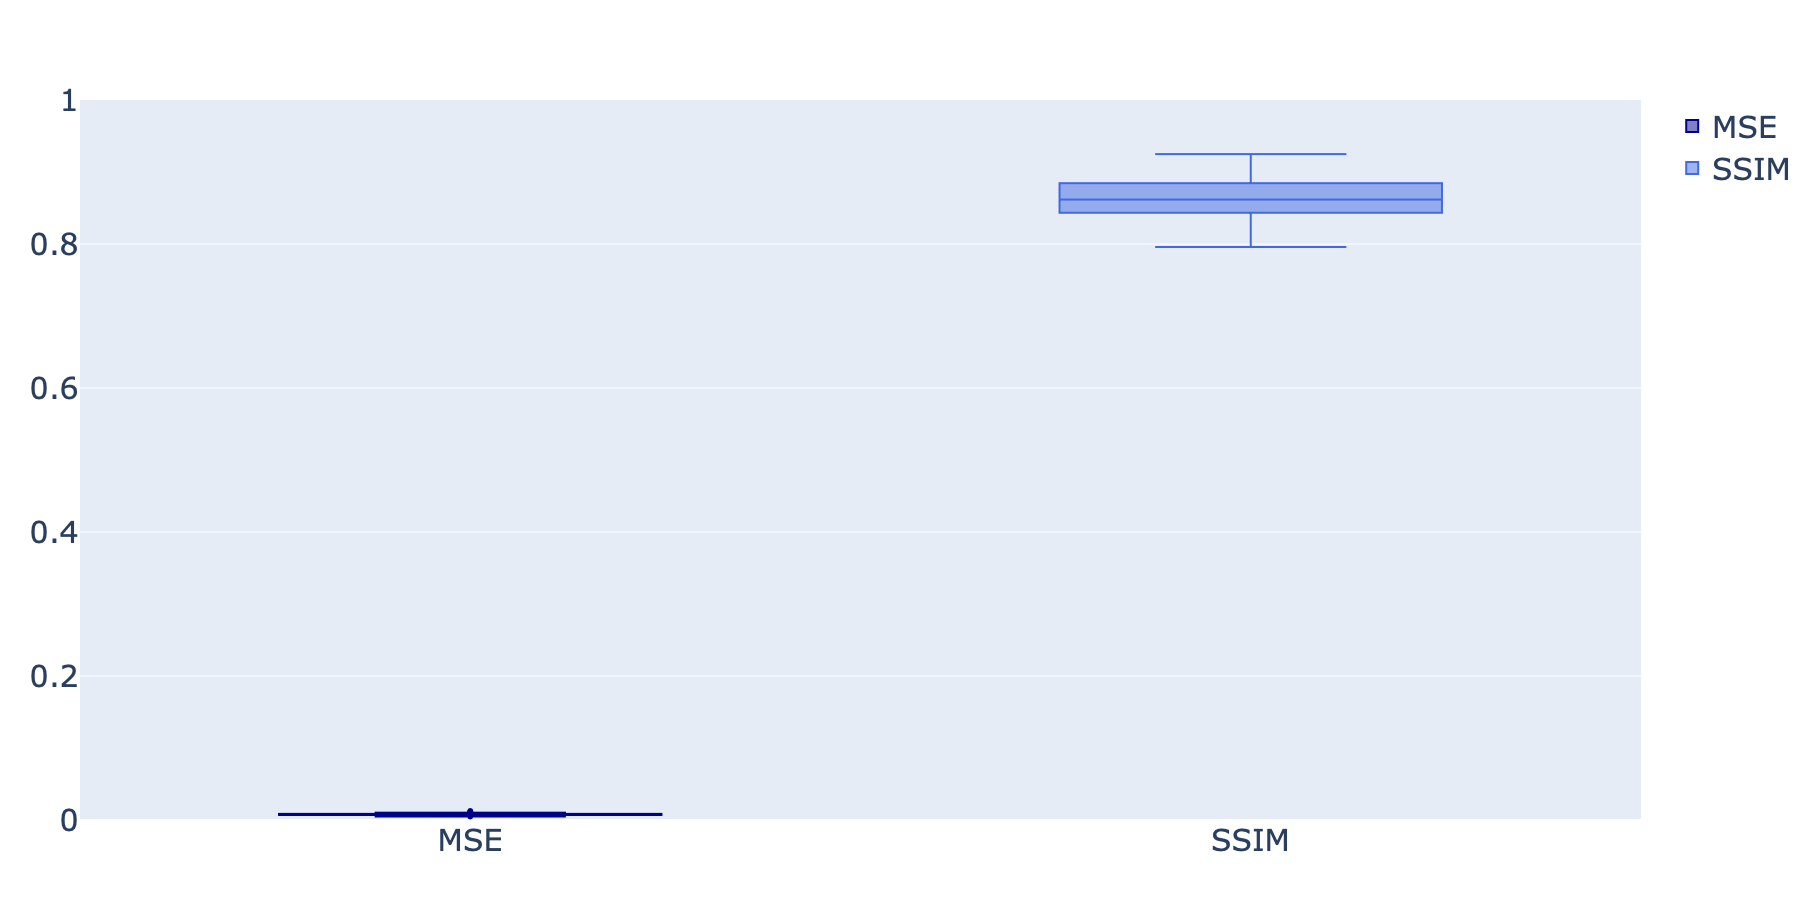

In [25]:
y0 = df.mse_noiseless
y1 = df.ssim_noiseless

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
# fig.write_image(model.RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}_{model.params["dataset"]}.png')

In [60]:
result_dict.keys()

dict_keys(['noiseless_results', '1_results', '5_results', '10_results', '15_results'])

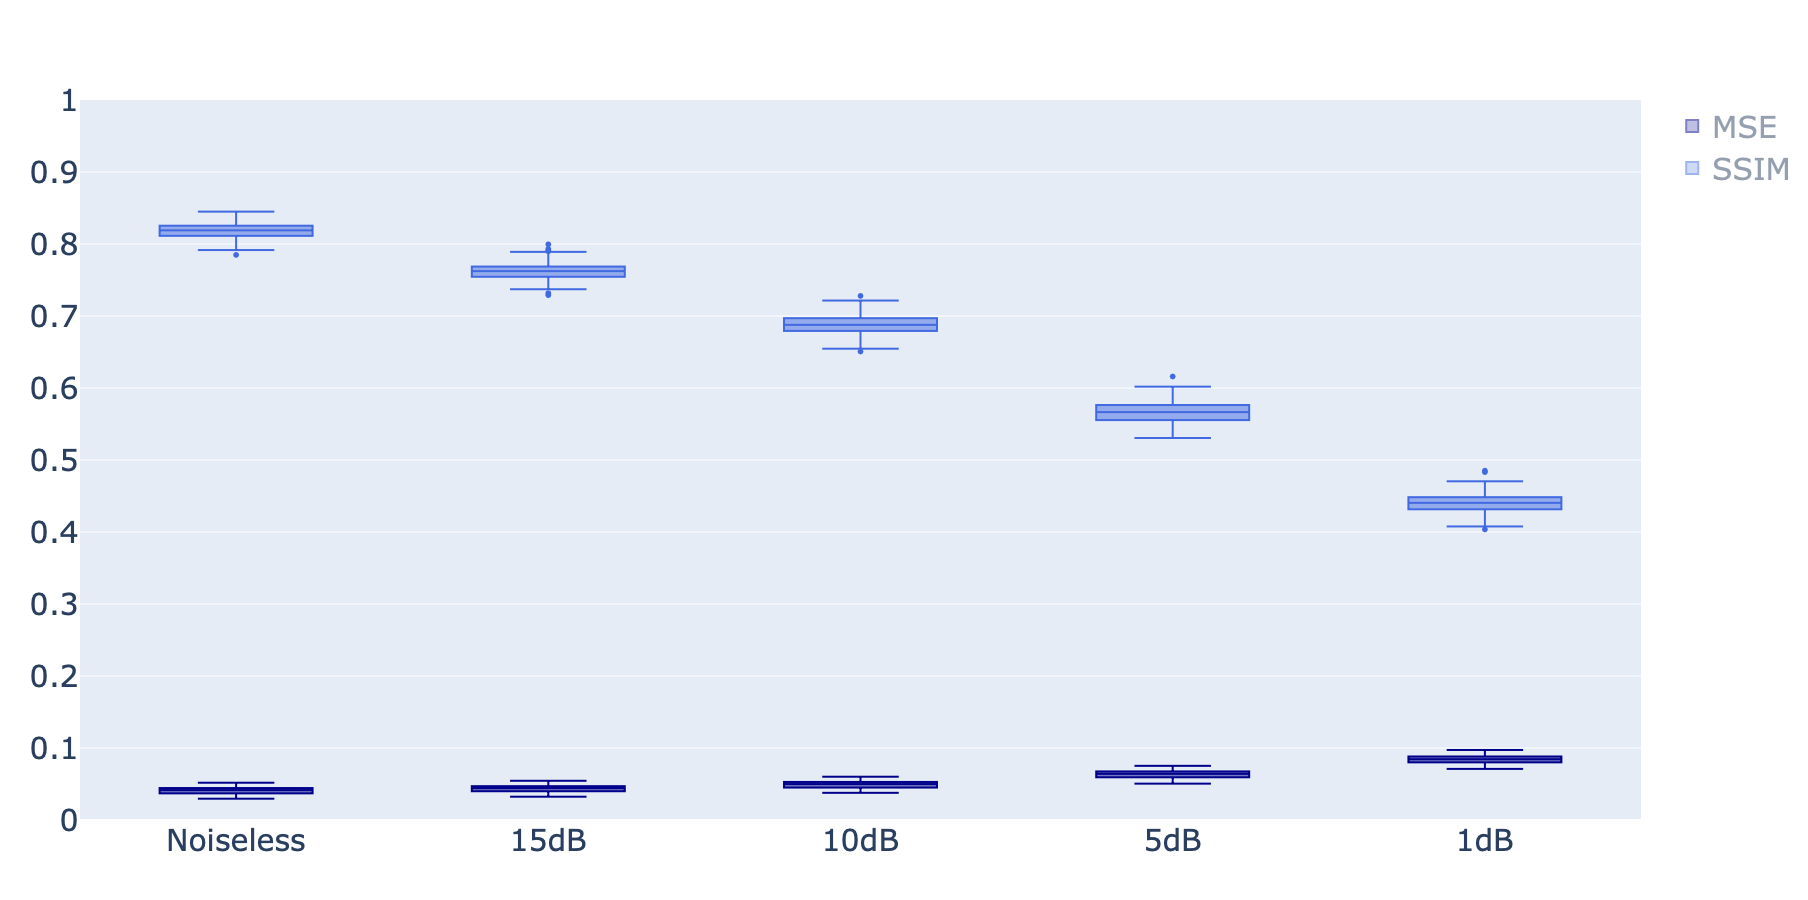

In [61]:
m0 = result_dict['noiseless_results'].mse_noiseless
s0 = result_dict['noiseless_results'].ssim_noiseless

m1 = result_dict['1_results'].mse_1
s1 = result_dict['1_results'].ssim_1

m5 = result_dict['5_results'].mse_5
s5 = result_dict['5_results'].ssim_5

m10 = result_dict['10_results'].mse_10
s10 = result_dict['10_results'].ssim_10

m15 = result_dict['15_results'].mse_15
s15 = result_dict['15_results'].ssim_15

fig = go.Figure()
fig.add_trace(go.Box(y=m0, name='Noiseless', marker_color = 'darkblue', showlegend=False))
fig.add_trace(go.Box(y=m15, name='15dB', marker_color = 'darkblue',showlegend=False))
fig.add_trace(go.Box(y=m10, name='10dB', marker_color = 'darkblue',showlegend=False))
fig.add_trace(go.Box(y=m5, name='5dB', marker_color = 'darkblue',showlegend=False))
fig.add_trace(go.Box(y=m1, name='1dB', marker_color = 'darkblue',showlegend=False))


fig.add_traces(go.Box(y=[''], name='MSE', marker_color = 'darkblue', visible='legendonly'))

fig.add_trace(go.Box(y=s0, name = 'Noiseless',marker_color = 'royalblue', showlegend=False))
fig.add_trace(go.Box(y=s15, name = '15dB',marker_color = 'royalblue',showlegend=False))
fig.add_trace(go.Box(y=s10, name = '10dB',marker_color = 'royalblue',showlegend=False))
fig.add_trace(go.Box(y=s5, name = '5dB',marker_color = 'royalblue',showlegend=False))
fig.add_trace(go.Box(y=s1, name = '1dB',marker_color = 'royalblue',showlegend=False))
fig.add_trace(go.Box(y=[''], name='SSIM', marker_color = 'royalblue', visible='legendonly'))


fig.update_layout(
    # title = '',
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        nticks=20,
        tickmode="auto",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
    # legend_title_text='Custom Legend Title',
    # legend=dict(
    #     x=0,
    #     y=1,
    #     traceorder='normal',
    #     font=dict(
    #         family='sans-serif',
    #         size=12,
    #         color='black'
    #     ),
    # # bgcolor='LightSteelBlue',
    # bordercolor='Black',
    # borderwidth=2)
)
fig.show(renderer="jupyterlab")
# fig.write_image(model.RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}.png')
# fig.write_image(model.RUN_DIR + f'FashionMNIST_all_noise_levels_results.png')

# Deconvolution method

In [23]:
D = testset.dataset[10]['img']
fft_D = torch.fft.fft2(D.squeeze(0))
fft_A = torch.fft.fft2(torch.Tensor(train_data.A))
invert = torch.fft.ifft2(fft_D/fft_A)
# recenter = torch.roll(invert, [int((model.img_size+1)/2),int((model.img_size+1)/2)], dims=(0,1))
recenter = torch.roll(invert, [round((model.img_size-1)/2),round((model.img_size-1)/2)], dims=(0,1))

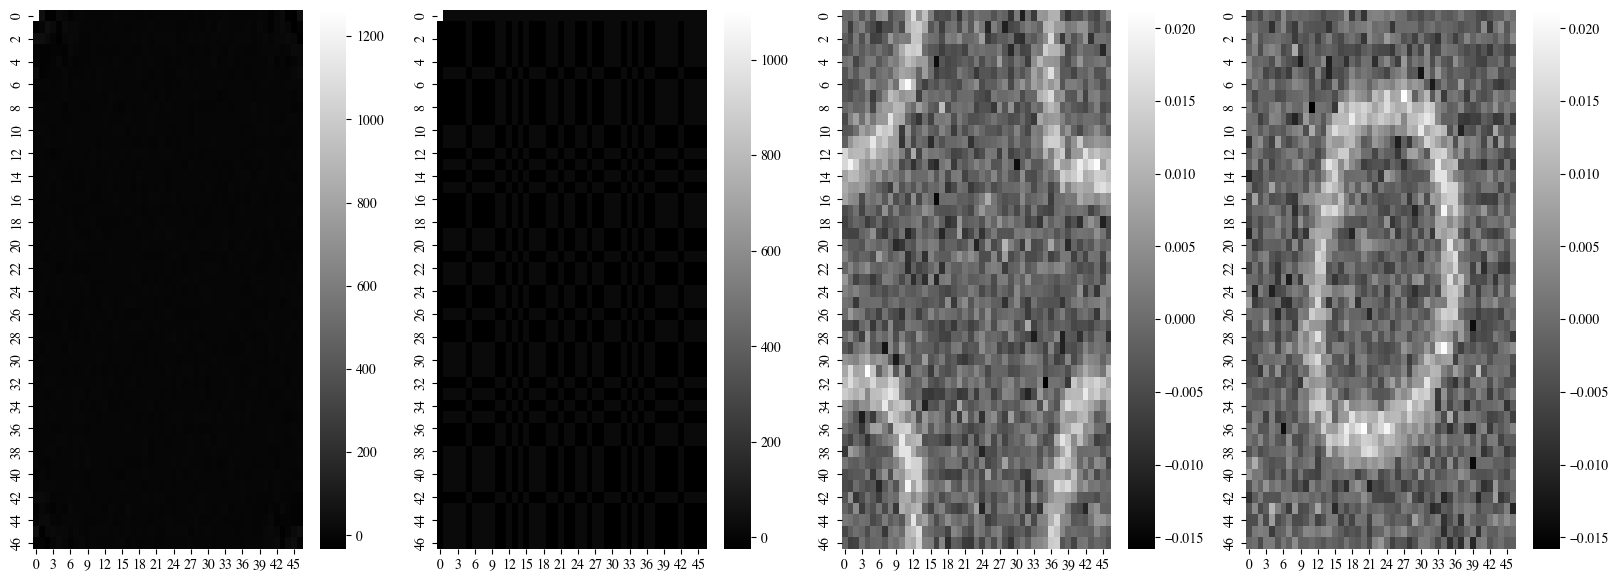

In [24]:
fig, axs = plt.subplots(1,4, figsize= (20,7))
axs = axs.ravel()
sns.heatmap(fft_D.real, ax=axs[0], cmap='gray')
sns.heatmap(fft_A.real, ax=axs[1], cmap='gray')
sns.heatmap(invert.real, ax=axs[2], cmap='gray')
sns.heatmap(recenter.real, ax=axs[3], cmap='gray')
plt.show()

# Rotate the weights

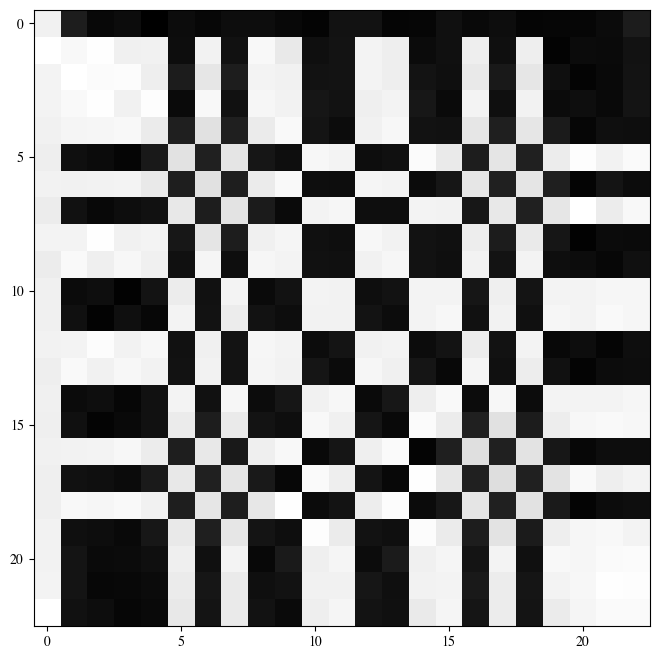

In [43]:
# Rotate the weights 180 degrees
weight_map = list(model.parameters())[0].squeeze(0).squeeze(0).detach()
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [8]:
from MURA import FFT_convolve

<Axes: >

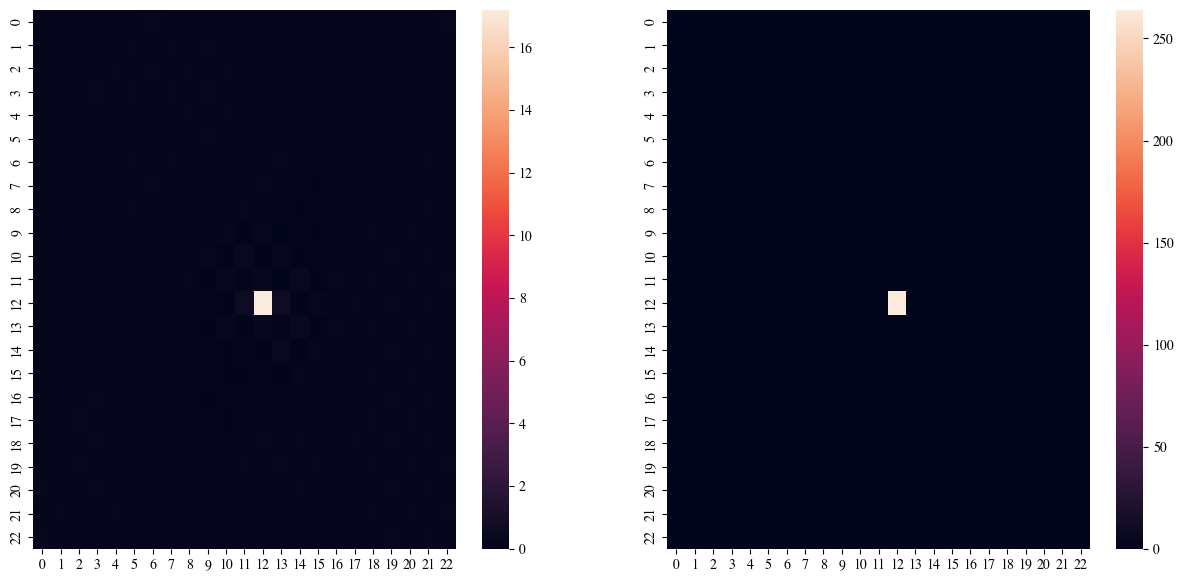

In [44]:
convolve_G_A = torch.Tensor(FFT_convolve(train_data.G, train_data.A))
convolve_G_L_A = torch.Tensor(FFT_convolve(w_rot180.numpy(), train_data.A))

fig, axs = plt.subplots(1,2, figsize=(15,7))
axs = axs.ravel()
sns.heatmap(convolve_G_L_A, ax= axs[0])
sns.heatmap(convolve_G_A, ax= axs[1])

In [28]:
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(11,11,11,11), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

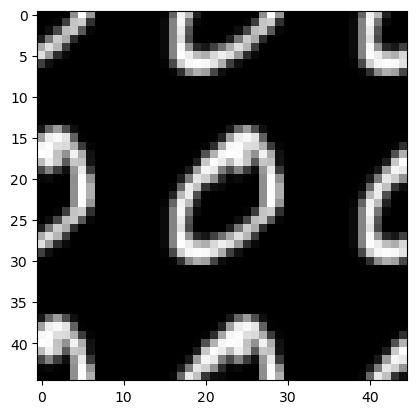

In [34]:
plt.imshow(padded_ex, cmap='gray')
plt.show()

# Open pickle

In [63]:
import pickle

# Specify the path to your pickle file
file_path = model.RUN_DIR+ 'weights_epoch.pkl'

# Open the pickle file in read mode
with open(file_path, 'rb') as f:
    # Load the data from the pickle file
    weights_per_epoch = pickle.load(f)